# **Plant Species Identification: Metric Learning with LoRA-DINOv2 & SVM**

This notebook implements a two-stage approach for plant species identification, specifically addressing the domain shift between herbarium (specimen) and field (live plant) images:

1.  **Metric Learning (DINOv2 + LoRA + Triplet Loss):** A DINOv2 vision transformer is used as the backbone. Low-Rank Adaptation (LoRA) is applied to fine-tune the backbone efficiently, and a metric learning approach with **Triplet Margin Loss** is used to learn an embedding space where images of the same species are close, and different species are far apart.
2.  **Linear Classification (SVM):** The learned embeddings are extracted for the training, validation, and test sets. A fast, robust **Linear Support Vector Machine (LinearSVC)** is trained on these embeddings to perform the final classification. This decouples the embedding learning from the final classification task.

## **1.0 Setup and Configuration** 

### **1.1 Library Imports**

In [1]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import warnings

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Sampler

# Computer Vision
import torchvision.transforms as T
import timm # Required for DINOv2 backbone
import kagglehub # Needed for model loading

# Metric Learning
from pytorch_metric_learning import losses, miners

# Classification & Evaluation
from sklearn.svm import LinearSVC
from sklearn.metrics import top_k_accuracy_score
from sklearn.model_selection import train_test_split 
import joblib

### **1.2 Configuration Constants**

In [ ]:
BASE_DIR = os.getcwd() 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Model & Training Parameters
EMBEDDING_DIM = 256  # Size of the final embedding space
BATCH_SIZE = 60 # Number of samples (triplets or images) processed per training iteration
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
MARGIN = 0.5         # Margin for TripletMarginLoss

# LoRA Parameters
LORA_RANK = 4        # Rank of the low-rank matrices 
LORA_ALPHA = 8       # Scaling factor to normalize the LoRA weights

# DINOv2 Backbone (ViT-B/14)
DINOV2_MODEL_NAME = 'vit_base_patch14_reg4_dinov2.lvd142m'
INPUT_SIZE = 224
DINOV2_FEATURES = 768 # Feature size before the custom embedding head

# Validation Split Ratio
VALIDATION_SPLIT_RATIO = 0.2

Using device: cuda


## **2.0 Data Handling**

### **2.1 Data Loading and Train/Validation Split**

In [ ]:
def load_data_lists(base_dir, val_split_ratio):
    
    list_dir = os.path.join(base_dir, 'data/list')

    # Load training data (path, class_id)
    train_data = []
    with open(os.path.join(list_dir, 'train.txt'), 'r') as f:
        for line in f:
            path, class_id = line.strip().split()
            domain = 'herbarium' if 'herbarium' in path else 'field'
            full_image_path = os.path.join(base_dir, 'data', path)
            train_data.append({'path': full_image_path, 
                               'class_id': int(class_id), 
                               'domain': domain})
    full_train_df = pd.DataFrame(train_data)
    
    # Load Test Ground Truth (path, class_id)
    test_data = []
    with open(os.path.join(list_dir, 'groundtruth.txt'), 'r') as f:
        for line in f:
            path, class_id = line.strip().split()
            full_image_path = os.path.join(base_dir, 'data', path)
            test_data.append({'path': full_image_path, 
                              'class_id': int(class_id), 
                              'domain': 'field'})
    test_df = pd.DataFrame(test_data)
    
    # Load Class grouping lists
    def load_class_ids(filename):
        with open(os.path.join(list_dir, filename), 'r') as f:
            return {int(line.strip()) for line in f}

    with_pairs_classes = load_class_ids('class_with_pairs.txt')
    without_pairs_classes = load_class_ids('class_without_pairs.txt')

    # Splitting logic for validation set 
    # Separate the herbarium-only classes (will stay in training)
    train_herbarium_only_df = full_train_df[full_train_df['class_id'].isin(without_pairs_classes)].copy()
    # Separate the classes with pairs (candidates for train/validation split)
    train_with_pairs_df = full_train_df[full_train_df['class_id'].isin(with_pairs_classes)].copy()
    
    # Perform stratified split ONLY on the 'with pairs' data
    train_split_df, val_df = train_test_split(
        train_with_pairs_df,
        test_size=val_split_ratio,
        stratify=train_with_pairs_df['class_id'],
        random_state=42 
    )
    
    # Combine the 'herbarium-only' data back with the main training split
    train_df = pd.concat([train_herbarium_only_df, train_split_df], ignore_index=True)
    
    print(f"Loaded {len(full_train_df)} total training samples across {full_train_df['class_id'].nunique()} species.")
    print(f"Split into {len(train_df)} training samples and {len(val_df)} validation samples.")
    print(f"Loaded {len(test_df)} test samples.")
    print(f"Species with pairs (validation candidates): {len(with_pairs_classes)}")
    print(f"Species without pairs (herbarium-only training): {len(without_pairs_classes)}")
    
    return train_df, val_df, test_df, with_pairs_classes, without_pairs_classes

# Load all data upfront
TRAIN_DF, VAL_DF, TEST_DF, WITH_PAIRS_CLASSES, WITHOUT_PAIRS_CLASSES = load_data_lists(BASE_DIR, VALIDATION_SPLIT_RATIO)

# Get all unique original class IDs
ALL_SPECIES = sorted(TRAIN_DF['class_id'].unique())
# Map original class IDs to contiguous 0-based indices
CLASS_TO_IDX = {class_id: idx for idx, class_id in enumerate(ALL_SPECIES)}
# Create a reverse mapping for human-readable output later
IDX_TO_CLASS = {idx: class_id for class_id, idx in CLASS_TO_IDX.items()} 
NUM_CLASSES = len(ALL_SPECIES)

print(f"Mapped {NUM_CLASSES} species to 0-based indices.")

Loaded 4744 total training samples across 100 species.
Split into 4144 training samples and 600 validation samples.
Loaded 207 test samples.
Species with pairs (validation candidates): 60
Species without pairs (herbarium-only training): 40
Mapped 100 species to 0-based indices.


### **2.2 Smart Augmentation Definitions**

In [ ]:
# Base transforms for all images
# Applies fundamental preprocessing required for the DINOv2 model.
BASE_TRANSFORM = T.Compose([
    T.Resize((INPUT_SIZE, INPUT_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Herbarium Augmentation (Simulate Field Conditions)
HERBARIUM_AUGMENT = T.Compose([
    T.RandomResizedCrop(INPUT_SIZE, scale=(0.8, 1.0)), # Random Cropping to simulate scale variation
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1), # Strong Color Jitter to simulate lighting/camera differences
    T.RandomApply([T.GaussianBlur(3, sigma=(0.1, 2.0))], p=0.3),    # Add potential blur/out-of-focus effect
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Field Augmentation (Light Augmentations)
FIELD_AUGMENT = T.Compose([
    T.RandomResizedCrop(INPUT_SIZE, scale=(0.9, 1.0)),  # Lighter cropping scale compared to herbarium
    T.RandomHorizontalFlip(),
    T.RandomRotation(degrees=10), # Random Rotations to increase geometric diversity
    T.ColorJitter(brightness=0.1, contrast=0.1), # Minor lighting/color variation
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Inference/Test Transform (No Augmentation)
INFERENCE_TRANSFORM = BASE_TRANSFORM

### **2.3 Custom PlantDataset Class and Initialization**

In [ ]:
class PlantDataset(Dataset):
    def __init__(self, dataframe, transform_h=None, transform_f=None, transform_inf=INFERENCE_TRANSFORM, is_train=True):
        self.dataframe = dataframe.copy()
        # Map original class IDs to PyTorch indices
        self.dataframe['idx_label'] = self.dataframe['class_id'].map(CLASS_TO_IDX)
        self.transform_h = transform_h  # Domain-specific augmentations (Herbarium)
        self.transform_f = transform_f  # Domain-specific augmentations (Field)
        self.transform_inf = transform_inf  # Transform used for validation and testing (no random augmentation)
        self.is_train = is_train

        # Pre-process for Triplet Sampling (if training)
        if self.is_train:
            self.class_to_indices = defaultdict(list)
            for i, row in self.dataframe.iterrows():
                self.class_to_indices[row['idx_label']].append(i)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        path = row['path']
        label = row['idx_label']
        domain = row['domain']
        
        # Load image
        img = Image.open(path).convert('RGB')
        
        # Apply Smart Augmentation/Transform
        if self.is_train:
            if domain == 'herbarium' and self.transform_h is not None:
                image = self.transform_h(img)
            elif domain == 'field' and self.transform_f is not None:
                image = self.transform_f(img)
            else:
                image = BASE_TRANSFORM(img) # Fallback
        else:
            # Use inference transform for test/evaluation
            image = self.transform_inf(img)

        # Return image, mapped label (idx_label), and original index
        return image, label, idx

# Initialize Datasets
train_dataset = PlantDataset(TRAIN_DF, 
                             transform_h=HERBARIUM_AUGMENT, 
                             transform_f=FIELD_AUGMENT, 
                             is_train=True)

# Validation Dataset (uses INFERENCE_TRANSFORM)
validation_dataset = PlantDataset(VAL_DF, is_train=False)

test_dataset = PlantDataset(TEST_DF, is_train=False)

## **3.0 Smart Triplet Sampler & DataLoaders**

In [ ]:
class SmartTripletSampler(Sampler):
    """
    Samples batches ensuring a class-balanced approach and prioritizing 
    'Herbarium-Only' species for balanced contribution.
    """
    def __init__(self, dataset, batch_size, num_triplets_per_epoch):
        self.dataset = dataset
        self.batch_size = batch_size
        self.num_triplets_per_epoch = num_triplets_per_epoch

        # Identify species groups by their mapped PyTorch indices
        self.all_classes = list(dataset.class_to_indices.keys())
        
        # Map original class IDs (from file) to PyTorch indices
        idx_with_pairs = {CLASS_TO_IDX[cid] for cid in WITH_PAIRS_CLASSES if cid in CLASS_TO_IDX}
        idx_without_pairs = {CLASS_TO_IDX[cid] for cid in WITHOUT_PAIRS_CLASSES if cid in CLASS_TO_IDX}

        self.priority_classes = list(idx_without_pairs) # Herbarium-Only species
        self.other_classes = list(idx_with_pairs) 

        # Create a weighted list of classes to sample:
        # Give higher probability to priority classes 
        self.sampling_classes = (self.priority_classes * 2) + self.other_classes
        if not self.sampling_classes:
             self.sampling_classes = self.all_classes # Fallback

        # Check if batch size is suitable for triplet mining (min 2 samples per class)
        if self.batch_size % 3 != 0 or self.batch_size < 3:
             print("WARNING: BATCH_SIZE should be a multiple of 3 (e.g., 60, 63) for effective batch mining.")


    def __iter__(self):
        # Use a list to store indices that will form the training batch
        all_indices = []
        
        # We need self.num_triplets_per_epoch * 3 total samples
        num_batches = int(np.ceil((self.num_triplets_per_epoch * 3) / self.batch_size))
        
        for _ in range(num_batches): 
            K = 8 # Number of classes per batch 
            
            # Sample K classes using the weighted list
            sampled_classes = random.choices(self.sampling_classes, k=K)
            
            # Sample N images from each selected class to form the batch
            batch_indices = []
            max_samples_per_class = self.batch_size // K 

            for c in sampled_classes:
                # Get all available indices for this class
                available_indices = self.dataset.class_to_indices[c]
                
                # Sample up to max_samples_per_class from this class 
                if len(available_indices) >= max_samples_per_class:
                    c_indices = random.sample(available_indices, max_samples_per_class)
                else:
                    # Sample with replacement if class is small
                    c_indices = random.choices(available_indices, k=max_samples_per_class)

                batch_indices.extend(c_indices)

            # Trim or pad the batch to ensure BATCH_SIZE
            if len(batch_indices) > self.batch_size:
                batch_indices = batch_indices[:self.batch_size]
            elif len(batch_indices) < self.batch_size:
                # Simple padding for simplicity, ideally we'd re-sample more classes
                padding_needed = self.batch_size - len(batch_indices)
                batch_indices.extend(random.choices(batch_indices, k=padding_needed))

            all_indices.extend(batch_indices)
            
        # Yield indices in chunks of BATCH_SIZE 
        for i in range(0, len(all_indices), self.batch_size):
            yield all_indices[i:i + self.batch_size]

    def __len__(self):
        # Total batches based on target triplets
        return int(np.ceil((self.num_triplets_per_epoch * 3) / self.batch_size))

# Initialize Sampler and DataLoaders
NUM_TRIPLETS_PER_EPOCH = len(train_dataset) # A good heuristic for epoch size
train_sampler = SmartTripletSampler(train_dataset, BATCH_SIZE, NUM_TRIPLETS_PER_EPOCH)

train_loader = DataLoader(
    train_dataset,
    batch_sampler=train_sampler,
    num_workers=0,
    pin_memory=True
)

# Validation Loader 
validation_loader = DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

## **4.0 Model Architecture Setup and Parameter-Efficient Fine-Tuning**

### **4.1 DINOv2 Backbone Loading and LoRA Implementation**

In [ ]:
# LoraLinear Implementation
class LoraLinear(nn.Module):
    def __init__(self, original_linear, r, alpha):
        super().__init__()
        
        self.r = r
        self.alpha = alpha
        self.scaling = alpha / r
        
        # Original layer parameters (Frozen)
        self.in_features = original_linear.in_features
        self.out_features = original_linear.out_features
        self.weight = original_linear.weight
        self.bias = original_linear.bias
        self.weight.requires_grad = False
        if self.bias is not None:
             self.bias.requires_grad = False
        
        # LoRA weights (Trainable)
        # A: (r, in_features), B: (out_features, r)
        self.lora_A = nn.Parameter(torch.zeros(r, self.in_features))
        self.lora_B = nn.Parameter(torch.zeros(self.out_features, r))
        
        # Initialization
        nn.init.kaiming_uniform_(self.lora_A, a=np.sqrt(5))
        nn.init.zeros_(self.lora_B) # Common practice to start with a zero delta

    def forward(self, x):
        # Original output (W*x + b)
        out = F.linear(x, self.weight, self.bias)
        
        # LoRA delta: (B*A)*x * scaling
        delta_W = self.lora_B @ self.lora_A
        lora_out = F.linear(x, delta_W, None) * self.scaling
        
        return out + lora_out

def apply_lora_to_dinov2(model, r, alpha):
    """
    Iterates through DINOv2 model layers and replaces nn.Linear with LoraLinear 
    in all attention qkv and proj layers.
    """
    for name, module in model.named_modules():
        # Target attention blocks inside the encoder blocks
        if 'attn' in name:
            # Specifically target the qkv (query/key/value) and proj (projection) layers
            if hasattr(module, 'qkv') and isinstance(module.qkv, nn.Linear):
                module.qkv = LoraLinear(module.qkv, r, alpha)
            if hasattr(module, 'proj') and isinstance(module.proj, nn.Linear):
                module.proj = LoraLinear(module.proj, r, alpha)
                
    return model


# DINOv2 Backbone Loading 
try:
    path_to_model_files = kagglehub.model_download("juliostat/dinov2_patch14_reg4_onlyclassifier_then_all/pyTorch/default")
    downloaded_files = os.listdir(path_to_model_files)

    timm_model_name = 'vit_base_patch14_reg4_dinov2.lvd142m'
    
    dinov2_backbone = timm.create_model(timm_model_name, 
                                        pretrained=False, 
                                        img_size=224) 

    dinov2_backbone.reset_classifier(0, '')
    
    weights_filename = next((f for f in downloaded_files if f.endswith(('.pth', '.pt', '.tar'))), None)
    if weights_filename is None:
        raise FileNotFoundError("Could not find a weights file.")

    weights_path = os.path.join(path_to_model_files, weights_filename)
    checkpoint = torch.load(weights_path, map_location='cpu', weights_only=False)
    state_dict = checkpoint.get('state_dict', checkpoint)

    # Positional Embedding Interpolation 
    if 'pos_embed' in state_dict:
        pos_embed_checkpoint = state_dict['pos_embed']
        pos_embed_model = dinov2_backbone.pos_embed 
        if pos_embed_checkpoint.shape != pos_embed_model.shape:
            N_src_tokens = pos_embed_checkpoint.shape[1]
            S_src = int(N_src_tokens**0.5)
            if S_src * S_src != N_src_tokens:
                 raise ValueError(f"Checkpoint positional embedding size {N_src_tokens} is not a perfect square.")
            S_tgt = 16 

            pos_embed_patches_src = pos_embed_checkpoint.reshape(1, S_src, S_src, -1 ).permute(0, 3, 1, 2) 
            pos_embed_patches_interpolated = F.interpolate(pos_embed_patches_src, size=(S_tgt, S_tgt), mode='bicubic', align_corners=False) 
            pos_embed_patches_interpolated = pos_embed_patches_interpolated.permute(0, 2, 3, 1).flatten(1, 2) 
            state_dict['pos_embed'] = pos_embed_patches_interpolated
            
    dinov2_backbone.load_state_dict(state_dict, strict=False)
    
except Exception as e:
    print(f"!!! FATAL ERROR during model loading. Error: {e}")
    dinov2_backbone = None
    raise

## **4.2 Model Definition (DINOv2 + LoRA + Embedding Head)**

In [ ]:
class DINOv2WithHead(nn.Module):
    def __init__(self, backbone, out_dim=EMBEDDING_DIM, r=LORA_RANK, alpha=LORA_ALPHA):
        super().__init__()
        
        self.backbone = backbone
        in_dim = self.backbone.num_features # 768 for ViT-B/14
        
        # Freeze entire DINOv2 backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        # Apply LoRA: Replaces target Linear layers with LoRaLinear
        self.backbone = apply_lora_to_dinov2(self.backbone, r, alpha)
        
        # Embedding Head Design (Trainable)
        self.embedding_head = nn.Sequential(
            nn.Linear(in_dim, in_dim // 2), 
            nn.BatchNorm1d(in_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_dim // 2, out_dim)
        )

    def forward(self, x):
        # Extract features using the backbone (now includes trainable LoRA layers)
        features = self.backbone.forward_features(x)
            
        # Mean pooling over tokens
        if features.dim() == 3: 
            features = features.mean(dim=1) 
            
        # Pass features through the trainable embedding head
        embedding = self.embedding_head(features)
        return embedding

# Initialize the full model using the loaded backbone
model = DINOv2WithHead(backbone=dinov2_backbone).to(DEVICE)
criterion = losses.TripletMarginLoss(margin=MARGIN).to(DEVICE)

# Semi-Hard mining for Triplet Loss
triplet_miner = miners.TripletMarginMiner(
    margin=MARGIN,
    type_of_triplets="semihard", 
).to(DEVICE)

# Optimizer trains ALL trainable parameters (LoRA weights + Embedding Head)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

## **5.0 Metric Learning Training Execution**

In [ ]:
# Helper function: Triplet Accuracy Calculation
def calculate_triplet_accuracy(embeddings, labels, criterion):
    """
    Calculates the Triplet Accuracy: proportion of triplets (a, p, n)
    where dist(a, p) < dist(a, n).
    
    This uses the same distance and margin logic as the TripletMarginLoss 
    for consistency, but computes it over all possible or mined triplets.
    """
    
    dist_matrix = torch.cdist(embeddings, embeddings, p=2.0)
    
    correct_count = 0
    total_count = 0
    
    # Find all possible triplets (a, p, n) within the batch
    # This is O(N^3) and very slow for large batches. It is for demonstration.
    N = embeddings.size(0)
    for i in range(N): # Anchor (a)
        for j in range(N): # Positive (p)
            if labels[i] == labels[j] and i != j:
                for k in range(N): # Negative (n)
                    if labels[i] != labels[k]:
                        dist_ap = dist_matrix[i, j]
                        dist_an = dist_matrix[i, k]
                        
                        # Triplet is correct if d(a, p) < d(a, n)
                        if dist_ap < dist_an:
                            correct_count += 1
                        total_count += 1
                        
    if total_count > 0:
        accuracy = correct_count / total_count
    else:
        # If no triplets could be formed, accuracy is 1.0 
        # We assume 1.0 if no pairs of different classes exist, meaning all same-class pairs are fine.
        accuracy = 1.0
        
    return accuracy, total_count


# Training Function
def train_one_epoch(model, criterion, miner, optimizer, data_loader, device):
    """Performs one epoch of triplet loss training with semi-hard mining."""
    model.train()
    total_loss = 0.0
    num_mined_triplets = 0
    total_accuracy = 0.0  # New accumulator for accuracy
    total_mined_for_accuracy = 0 # New accumulator for total triplets where accuracy is calculated
    
    progress_bar = tqdm(data_loader, desc=f"Training Epoch", leave=False)

    for images, labels, _ in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(images)
        triplet_indices = miner(embeddings, labels) # Semi-hard triplets for loss
        
        if triplet_indices[0].numel() > 0:
            loss = criterion(embeddings, labels, triplet_indices)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * len(images)
            num_mined_triplets += triplet_indices[0].numel()
            
            # Accuracy calculation on the whole batch embeddings
            batch_acc, batch_triplets = calculate_triplet_accuracy(embeddings.detach(), labels, criterion)
            total_accuracy += batch_acc * batch_triplets
            total_mined_for_accuracy += batch_triplets
            
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}', 
                'Triplets': num_mined_triplets,
                'Acc': f'{batch_acc:.4f}'
            })

    avg_loss = total_loss / len(data_loader.dataset)
    
    # Calculate average accuracy over all calculated batches
    avg_accuracy = total_accuracy / total_mined_for_accuracy if total_mined_for_accuracy > 0 else 0.0
    
    return avg_loss, avg_accuracy, num_mined_triplets

# Validation Function
def validate_one_epoch(model, criterion, data_loader, device):
    """Calculates the triplet loss and accuracy on the validation set."""
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0 # New accumulator for accuracy
    total_mined_for_accuracy = 0 # New accumulator for total triplets where accuracy is calculated
    
    with torch.no_grad():
        for images, labels, _ in data_loader:
            images, labels = images.to(device), labels.to(device)
            embeddings = model(images)
            
            loss = criterion(embeddings, labels)
            total_loss += loss.item() * len(images)
            
            # Accuracy calculation on the whole batch embeddings 
            batch_acc, batch_triplets = calculate_triplet_accuracy(embeddings, labels, criterion)
            total_accuracy += batch_acc * batch_triplets
            total_mined_for_accuracy += batch_triplets


    avg_loss = total_loss / len(data_loader.dataset)
    
    # Calculate average accuracy over all calculated batches
    avg_accuracy = total_accuracy / total_mined_for_accuracy if total_mined_for_accuracy > 0 else 0.0
    
    return avg_loss, avg_accuracy

In [ ]:
# Main Training Execution
train_losses = []
val_losses = []
train_accuracies = [] 
val_accuracies = []   

print("\nStarting Triplet Loss Training with LoRA...")
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc, mined_triplets = train_one_epoch(
        model, criterion, triplet_miner, optimizer, train_loader, DEVICE
    )
    val_loss, val_acc = validate_one_epoch(model, criterion, validation_loader, DEVICE)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc) # Store train accuracy
    val_accuracies.append(val_acc)     # Store validation accuracy
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}, Mined Triplet Count = {mined_triplets}")

# Save the trained parameters (LoRA weights and Embedding Head weights)
torch.save(model.state_dict(), os.path.join(BASE_DIR, 'model_with_lora_final.pth'))
print("Training complete. Model weights (LoRA + Head) saved.")


Starting Triplet Loss Training with LoRA...


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 1/20: Train Loss = 0.7800, Val Loss = 0.4846, Train Acc = 0.8005, Val Acc = 0.7854, Mined Triplet Count = 1853925


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 2/20: Train Loss = 0.6781, Val Loss = 0.4208, Train Acc = 0.8914, Val Acc = 0.8483, Mined Triplet Count = 1154741


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 3/20: Train Loss = 0.6611, Val Loss = 0.4059, Train Acc = 0.9098, Val Acc = 0.8509, Mined Triplet Count = 1030498


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 4/20: Train Loss = 0.6473, Val Loss = 0.4011, Train Acc = 0.9243, Val Acc = 0.8629, Mined Triplet Count = 924380


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 5/20: Train Loss = 0.6347, Val Loss = 0.3920, Train Acc = 0.9351, Val Acc = 0.8775, Mined Triplet Count = 846509


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 6/20: Train Loss = 0.6293, Val Loss = 0.3883, Train Acc = 0.9406, Val Acc = 0.8776, Mined Triplet Count = 818307


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 7/20: Train Loss = 0.6158, Val Loss = 0.3731, Train Acc = 0.9473, Val Acc = 0.8860, Mined Triplet Count = 764269


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 8/20: Train Loss = 0.6092, Val Loss = 0.3752, Train Acc = 0.9520, Val Acc = 0.8826, Mined Triplet Count = 721804


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 9/20: Train Loss = 0.6078, Val Loss = 0.3682, Train Acc = 0.9548, Val Acc = 0.8955, Mined Triplet Count = 708522


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 10/20: Train Loss = 0.5916, Val Loss = 0.3747, Train Acc = 0.9636, Val Acc = 0.8964, Mined Triplet Count = 629486


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 11/20: Train Loss = 0.5915, Val Loss = 0.3693, Train Acc = 0.9652, Val Acc = 0.8964, Mined Triplet Count = 624020


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 12/20: Train Loss = 0.5847, Val Loss = 0.3668, Train Acc = 0.9659, Val Acc = 0.8959, Mined Triplet Count = 602141


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 13/20: Train Loss = 0.5850, Val Loss = 0.3627, Train Acc = 0.9681, Val Acc = 0.8939, Mined Triplet Count = 562416


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 14/20: Train Loss = 0.5833, Val Loss = 0.3701, Train Acc = 0.9699, Val Acc = 0.9015, Mined Triplet Count = 552307


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 15/20: Train Loss = 0.5703, Val Loss = 0.3607, Train Acc = 0.9721, Val Acc = 0.9015, Mined Triplet Count = 522589


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 16/20: Train Loss = 0.5668, Val Loss = 0.3657, Train Acc = 0.9745, Val Acc = 0.8964, Mined Triplet Count = 514607


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 17/20: Train Loss = 0.5587, Val Loss = 0.3618, Train Acc = 0.9753, Val Acc = 0.9025, Mined Triplet Count = 502456


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 18/20: Train Loss = 0.5556, Val Loss = 0.3654, Train Acc = 0.9769, Val Acc = 0.8978, Mined Triplet Count = 490012


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 19/20: Train Loss = 0.5495, Val Loss = 0.3583, Train Acc = 0.9796, Val Acc = 0.8978, Mined Triplet Count = 438848


Training Epoch:   0%|          | 0/208 [00:00<?, ?it/s]

Epoch 20/20: Train Loss = 0.5403, Val Loss = 0.3536, Train Acc = 0.9812, Val Acc = 0.9041, Mined Triplet Count = 414836
Training complete. Model weights (LoRA + Head) saved.


## **6.0 Visualization of Training History**

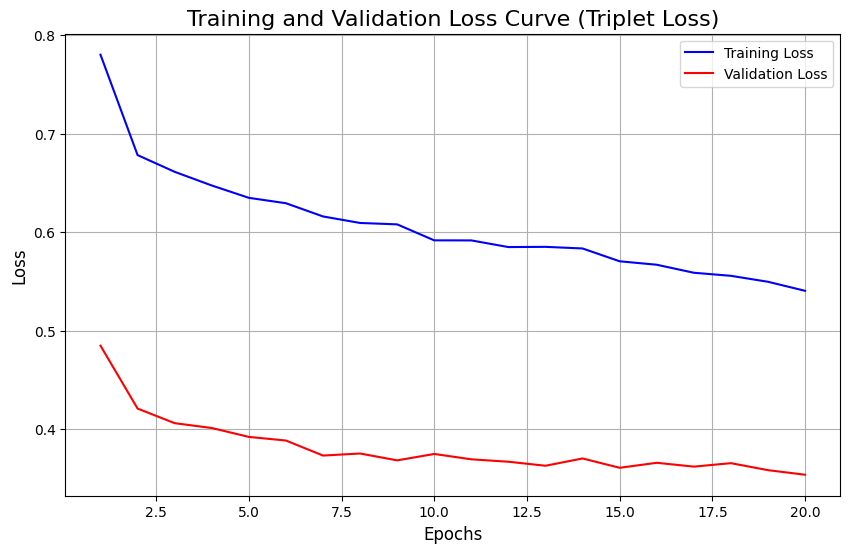

Loss curve saved as 'triplet_loss_curve.png'


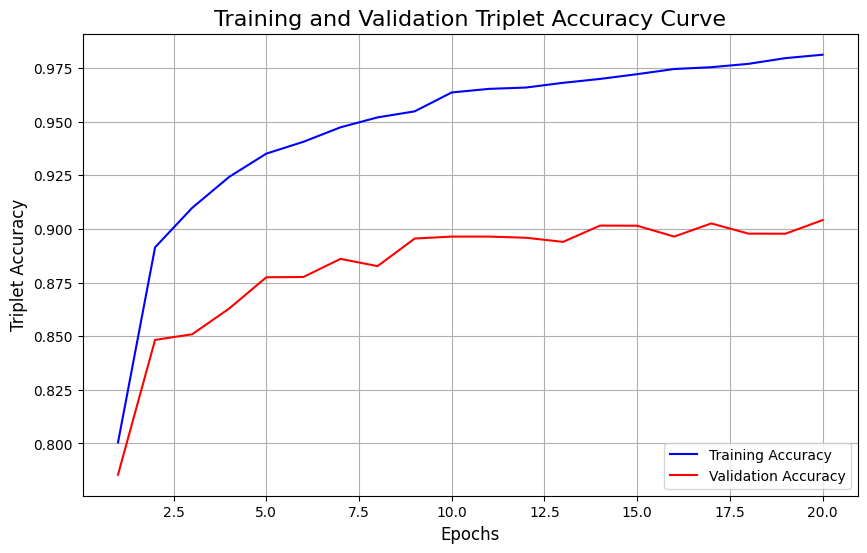

Accuracy curve saved as 'triplet_accuracy_curve.png'


In [21]:
## Plotting Loss and Accuracy Curves

# Ensure there is data to plot before proceeding
if len(train_losses) > 0:
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss Curve 
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.plot(epochs, val_losses, 'r', label='Validation Loss')
    
    plt.title('Training and Validation Loss Curve (Triplet Loss)', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.savefig('triplet_loss_curve.png') # Save the plot
    plt.show() 
    print("Loss curve saved as 'triplet_loss_curve.png'")
    
    # Plot Accuracy Curve 
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy') 
    plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy') 
    
    plt.title('Training and Validation Triplet Accuracy Curve', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Triplet Accuracy', fontsize=12)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig('triplet_accuracy_curve.png') # Save the plot
    plt.show() 
    print("Accuracy curve saved as 'triplet_accuracy_curve.png'")
    
else:
    print("No training losses recorded. Skipping loss and accuracy curve plots.")

## **7.0 Feature Extraction**

In [ ]:
def extract_embeddings(model, data_loader, device):
    """Extracts embeddings and corresponding labels for a given dataset."""
    model.eval()
    embeddings_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels, _ in tqdm(data_loader, desc="Extracting Embeddings"):
            images = images.to(device)
            embeddings = model(images).cpu().numpy()
            
            embeddings_list.append(embeddings)
            labels_list.append(labels.cpu().numpy())

    # Concatenate all batch results into single NumPy arrays (X for features, y for labels)
    return np.concatenate(embeddings_list), np.concatenate(labels_list)

# Extract Embeddings for SVM Training and Testing
print("\nExtracting Training Embeddings...")
X_train_embed, y_train_labels = extract_embeddings(model, train_loader, DEVICE)

print("Extracting Test Embeddings...")
X_test_embed, y_test_labels = extract_embeddings(model, test_loader, DEVICE)

print(f"Train embeddings shape: {X_train_embed.shape}")
print(f"Test embeddings shape: {X_test_embed.shape}")


Extracting Training Embeddings...


Extracting Embeddings:   0%|          | 0/208 [00:00<?, ?it/s]

Extracting Test Embeddings...


Extracting Embeddings:   0%|          | 0/4 [00:00<?, ?it/s]

Train embeddings shape: (12480, 256)
Test embeddings shape: (207, 256)


## **8.0 Linear SVM Classifier Training & Evaluation**

In [17]:
# Evaluates Top-K accuracy on overall and subsets of the test set
def evaluate_subsets(classifier, X_embed, y_labels, with_pairs_classes, without_pairs_classes, all_classes, num_classes):
    
    # Map original class IDs to 0-based indices for filtering
    idx_with_pairs = {CLASS_TO_IDX[cid] for cid in with_pairs_classes if cid in CLASS_TO_IDX}
    idx_without_pairs = {CLASS_TO_IDX[cid] for cid in without_pairs_classes if cid in CLASS_TO_IDX}
    
    # Get predicted decision scores (or distances)
    y_scores = classifier.decision_function(X_embed)

    results = {}

    # Helper function for evaluation 
    def compute_accuracy(scores, true_labels, subset_mask, labels_range):
        if not np.any(subset_mask):
            return 0.0, 0.0, 0 # Return zeros if subset is empty
        
        subset_scores = scores[subset_mask]
        subset_labels = true_labels[subset_mask]
        
        top1_acc = top_k_accuracy_score(subset_labels, subset_scores, k=1, labels=labels_range)
        top5_acc = top_k_accuracy_score(subset_labels, subset_scores, k=5, labels=labels_range)
        
        return top1_acc, top5_acc, len(subset_labels)

    # Overall Evaluation 
    top1_acc, top5_acc, count = compute_accuracy(y_scores, y_labels, np.ones(len(y_labels), dtype=bool), np.arange(num_classes))
    results['Overall'] = (top1_acc, top5_acc, count)

    # Classes With Pairs Evaluation 
    mask_with_pairs = np.array([label in idx_with_pairs for label in y_labels])
    top1_acc_wp, top5_acc_wp, count_wp = compute_accuracy(y_scores, y_labels, mask_with_pairs, np.arange(num_classes))
    results['Classes With Pairs'] = (top1_acc_wp, top5_acc_wp, count_wp)

    # Classes Herbarium Only Evaluation (Without Pairs) 
    mask_without_pairs = np.array([label in idx_without_pairs for label in y_labels])
    top1_acc_wo, top5_acc_wo, count_wo = compute_accuracy(y_scores, y_labels, mask_without_pairs, np.arange(num_classes))
    results['Classes Herbarium Only'] = (top1_acc_wo, top5_acc_wo, count_wo)
    
    return results

# Train Linear SVM Classifier
print("\nTraining Linear SVC Classifier...")
classifier = LinearSVC(random_state=42, C=1.0) 
# X_train_embed and y_train_labels must be defined
classifier.fit(X_train_embed, y_train_labels) 
print("Linear SVC Training complete.")

# Evaluation (Top-K Accuracy) 
print("Evaluating Top-K Accuracy...")

with warnings.catch_warnings():
    # Ignore the UserWarning from scikit-learn's _ranking.py
    warnings.filterwarnings(
        "ignore", 
        message="The number of unique classes is greater than 50% of the number of samples.*", 
        category=UserWarning
    )
    
    # Run the evaluation inside the context manager
    results = evaluate_subsets(
        classifier, 
        X_test_embed, 
        y_test_labels, 
        WITH_PAIRS_CLASSES, 
        WITHOUT_PAIRS_CLASSES, 
        ALL_SPECIES, 
        NUM_CLASSES
    )

print("\n--- Standard Test Set Results ---")
for key, (top1, top5, count) in results.items():
    print(f"| {key.ljust(30)} | Samples: {str(count).ljust(4)} | Top-1 Acc: {top1*100:.2f}% | Top-5 Acc: {top5*100:.2f}% |")


Training Linear SVC Classifier...
Linear SVC Training complete.
Evaluating Top-K Accuracy...

--- Standard Test Set Results ---
| Overall                        | Samples: 207  | Top-1 Acc: 62.80% | Top-5 Acc: 75.36% |
| Classes With Pairs             | Samples: 153  | Top-1 Acc: 77.78% | Top-5 Acc: 89.54% |
| Classes Herbarium Only         | Samples: 54   | Top-1 Acc: 20.37% | Top-5 Acc: 35.19% |


In [ ]:
SVC_SAVE_PATH = "svc_classifier_final.joblib" 

# Saving the SVC Classifier 
try:
    joblib.dump(classifier, SVC_SAVE_PATH)
    print(f"\n SVC Classifier successfully saved to: {SVC_SAVE_PATH}")
except NameError:
    print("\n ERROR: 'svc_classifier' is not defined. Ensure you run the SVC training cell first.")
except Exception as e:
    print(f"\n ERROR saving SVC: {e}")


 SVC Classifier successfully saved to: svc_classifier_final.joblib


## **9.0 Test-Time Augmentation (TTA)**

In [ ]:
# Helper function to extract embeddings with a specific transform 
def extract_embeddings_with_transform(model, df, transform, batch_size, device):
    
    # Create a dataset, forcing the use of the provided 'transform' as the inference transform
    tta_dataset = PlantDataset(df, transform_inf=transform, is_train=False)
    tta_loader = DataLoader(
        tta_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    
    # Use the existing extraction function
    X_embed, y_labels = extract_embeddings(model, tta_loader, device)
    return X_embed, y_labels

def predict_with_tta(model, test_df, classifier, num_tta=5, device=DEVICE):
    """
    Fully implemented Test-Time Augmentation (TTA) using averaging of predictions.
    
    """
    
    # The transform used for TTA is a light augmentation transform (FIELD_AUGMENT)
    tta_transform = FIELD_AUGMENT 
    
    all_tta_scores = []
    
    print(f"\nStarting TTA with {num_tta} passes...")
    
    for t in range(num_tta):
        print(f"  -> Running TTA pass {t+1}/{num_tta}...")
        
        # We set a different random seed for each pass to ensure different augmentations
        torch.manual_seed(42 + t)
        random.seed(42 + t)
        np.random.seed(42 + t)

        # Extract TTA embeddings using the augmenting transform
        X_tta_embed, y_tta_labels_check = extract_embeddings_with_transform(
            model, 
            test_df, 
            tta_transform, 
            BATCH_SIZE, 
            device
        )
        
        # Get decision scores from the trained SVC
        tta_scores = classifier.decision_function(X_tta_embed)
        all_tta_scores.append(tta_scores)

    # Average the scores across all TTA passes
    avg_tta_scores = np.mean(all_tta_scores, axis=0)
    
    # Re-evaluate with averaged scores 
    
    # Reset the random seed for the final evaluation to ensure reproducibility
    torch.manual_seed(42)
    random.seed(42)
    np.random.seed(42)
    
    # Re-computing subset accuracies using the averaged scores:
    
    # Map original class IDs to 0-based indices for filtering
    idx_with_pairs = {CLASS_TO_IDX[cid] for cid in WITH_PAIRS_CLASSES if cid in CLASS_TO_IDX}
    idx_without_pairs = {CLASS_TO_IDX[cid] for cid in WITHOUT_PAIRS_CLASSES if cid in CLASS_TO_IDX}
    
    # Overall
    tta_top1_acc = top_k_accuracy_score(y_test_labels, avg_tta_scores, k=1, labels=np.arange(NUM_CLASSES))
    tta_top5_acc = top_k_accuracy_score(y_test_labels, avg_tta_scores, k=5, labels=np.arange(NUM_CLASSES))

    # With Pairs
    mask_with_pairs = np.array([label in idx_with_pairs for label in y_test_labels])
    tta_top1_acc_wp = top_k_accuracy_score(y_test_labels[mask_with_pairs], avg_tta_scores[mask_with_pairs], k=1, labels=np.arange(NUM_CLASSES))
    tta_top5_acc_wp = top_k_accuracy_score(y_test_labels[mask_with_pairs], avg_tta_scores[mask_with_pairs], k=5, labels=np.arange(NUM_CLASSES))

    # Herbarium Only
    mask_without_pairs = np.array([label in idx_without_pairs for label in y_test_labels])
    tta_top1_acc_wo = top_k_accuracy_score(y_test_labels[mask_without_pairs], avg_tta_scores[mask_without_pairs], k=1, labels=np.arange(NUM_CLASSES))
    tta_top5_acc_wo = top_k_accuracy_score(y_test_labels[mask_without_pairs], avg_tta_scores[mask_without_pairs], k=5, labels=np.arange(NUM_CLASSES))
    
    
    print("\n--- TTA Test Set Results (Score Averaging) ---")
    print(f"| {'Overall'.ljust(30)} | Samples: {str(len(y_test_labels)).ljust(4)} | Top-1 Acc: {tta_top1_acc*100:.2f}% | Top-5 Acc: {tta_top5_acc*100:.2f}% |")
    print(f"| {'Classes With Pairs'.ljust(30)} | Samples: {str(sum(mask_with_pairs)).ljust(4)} | Top-1 Acc: {tta_top1_acc_wp*100:.2f}% | Top-5 Acc: {tta_top5_acc_wp*100:.2f}% |")
    print(f"| {'Classes Herbarium Only'.ljust(30)} | Samples: {str(sum(mask_without_pairs)).ljust(4)} | Top-1 Acc: {tta_top1_acc_wo*100:.2f}% | Top-5 Acc: {tta_top5_acc_wo*100:.2f}% |")
    
    return tta_top1_acc, tta_top5_acc, avg_tta_scores, y_test_labels 

with warnings.catch_warnings():
    # Ignore the specific UserWarning from scikit-learn's _ranking.py
    warnings.filterwarnings(
        "ignore", 
        message="The number of unique classes is greater than 50% of the number of samples.*", 
        category=UserWarning
    )
    
    # Run TTA for final evaluation
    TTA_TOP1, TTA_TOP5, AVG_TTA_SCORES, Y_TEST_LABELS_FINAL = predict_with_tta(model, TEST_DF, classifier, num_tta=5, device=DEVICE)


Starting TTA with 5 passes...
  -> Running TTA pass 1/5...


Extracting Embeddings:   0%|          | 0/4 [00:00<?, ?it/s]

  -> Running TTA pass 2/5...


Extracting Embeddings:   0%|          | 0/4 [00:00<?, ?it/s]

  -> Running TTA pass 3/5...


Extracting Embeddings:   0%|          | 0/4 [00:00<?, ?it/s]

  -> Running TTA pass 4/5...


Extracting Embeddings:   0%|          | 0/4 [00:00<?, ?it/s]

  -> Running TTA pass 5/5...


Extracting Embeddings:   0%|          | 0/4 [00:00<?, ?it/s]


--- TTA Test Set Results (Score Averaging) ---
| Overall                        | Samples: 207  | Top-1 Acc: 61.35% | Top-5 Acc: 75.85% |
| Classes With Pairs             | Samples: 153  | Top-1 Acc: 75.82% | Top-5 Acc: 90.20% |
| Classes Herbarium Only         | Samples: 54   | Top-1 Acc: 20.37% | Top-5 Acc: 35.19% |


## **10.0 Prediction Visualization**


--- Visualizing 10 Random Test Predictions ---


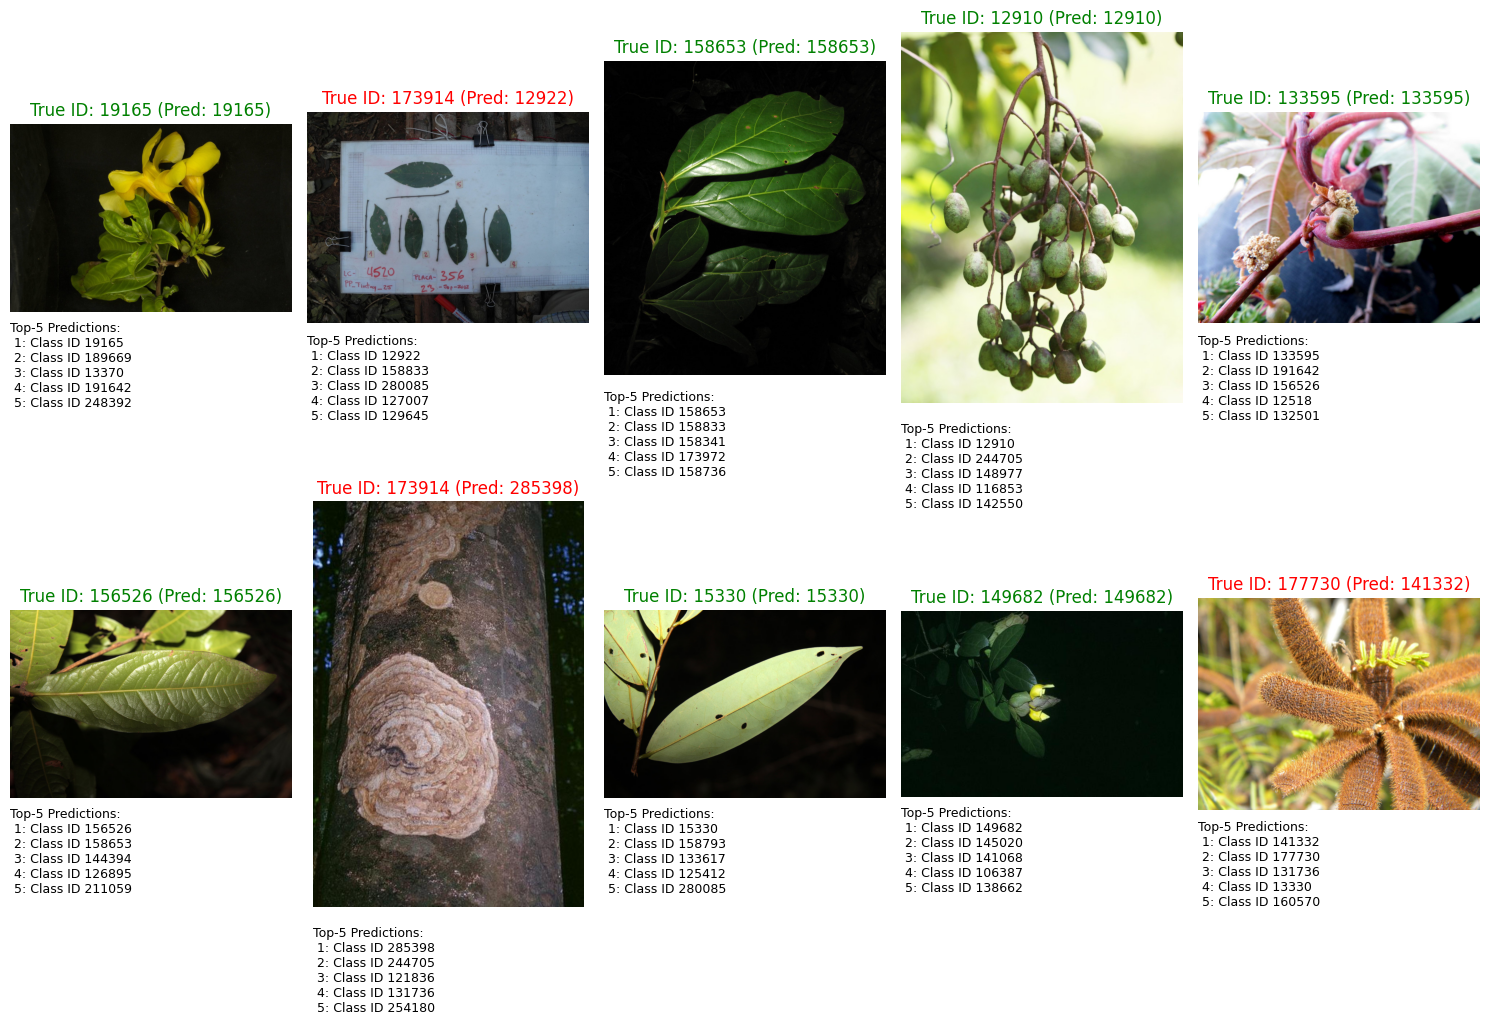

In [ ]:
def visualize_predictions(test_df, y_true_idx, avg_scores, idx_to_class_map, num_samples=5):
    """
    Selects random test samples, displays the image, and shows the Top-5 predictions 
    based on the TTA-averaged scores.
    """
    
    print(f"\n--- Visualizing {num_samples} Random Test Predictions ---")
    
    # Get the indices of the samples to visualize
    sample_indices = random.sample(range(len(test_df)), num_samples)
    
    # Determine Top-K Predictions (Top-5)
    top_k = 5
    predicted_indices = np.argsort(avg_scores, axis=1)[:, ::-1][:, :top_k]

    # Create subplots
    fig, axes = plt.subplots(2, 5, figsize=(15, 10)) 
    
    # Flatten the 2x5 array of axes into a 1D array of 10 axes for easy iteration
    axes = axes.flatten() 

    # Only iterate over the selected number of samples
    for i, test_idx in enumerate(sample_indices):
        # Use the flattened axes array for simple indexing
        ax = axes[i] 
        
        # Get ground truth (mapped to original class ID)
        true_idx = y_true_idx[test_idx]
        true_class_id = idx_to_class_map[true_idx]
        
        # Get image path
        img_path = test_df.iloc[test_idx]['path']
        img = Image.open(img_path).convert('RGB')
        
        # Get predictions (mapped to original class IDs)
        top_5_indices = predicted_indices[test_idx]
        top_5_class_ids = [idx_to_class_map[idx] for idx in top_5_indices]
        
        # Display Image
        ax.imshow(img)
        ax.axis('off')

        top1_pred_id = top_5_class_ids[0]
        is_correct = (top1_pred_id == true_class_id)
        title_color = 'green' if is_correct else 'red'
        
        # Title now only shows True ID and Top-1 Prediction Status
        ax.set_title(f"True ID: {true_class_id} (Pred: {top1_pred_id})", 
                     fontsize=12, color=title_color)
        
        # Generate clean prediction text
        pred_lines = [f" {k+1}: Class ID {cid}" for k, cid in enumerate(top_5_class_ids)]
        pred_text = "Top-5 Predictions:\n" + "\n".join(pred_lines)
        
        # Place the prediction text using ax.text at normalized coordinates
        ax.text(
            0.0, -0.05, # Position: 0% X (left edge), 5% below bottom edge of image
            pred_text, 
            transform=ax.transAxes, 
            fontsize=9, 
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2') # Optional background box
        )
        
    # Use tight_layout to automatically adjust subplot parameters for a tight layout
    plt.tight_layout()
    # Use plt.subplots_adjust to ensure the bottom text blocks have enough space vertically
    plt.subplots_adjust(hspace=0.2) 
    plt.show()

# Execute Visualization (visualize 10 random samples)
visualize_predictions(
    TEST_DF, 
    Y_TEST_LABELS_FINAL, 
    AVG_TTA_SCORES, 
    IDX_TO_CLASS, 
    num_samples=10 
)